<span style="color:black;font-size:35px">**TODO - header**</span>

In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import sys
#sys.path.append(r'..\models')
sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\models')
from vgg import VGG16
from lenet import LeNet
sys.path.pop()
#sys.path.append(r'..\training')
sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\training')
from training import train_epoch
sys.path.pop()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#FILEPATH = r"..\..\FISH0006 fishclassifierfinal\intel-image-classification"
FILEPATH = r"C:\Users\hansm\Github\CIS472-CourseProject\Project Datasets\Dataset3\FishClassifierFinal\archive\intel-image-classification"

In [2]:
def evaluate(model, test_data):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for (data, label) in test_data:
#             print(data)
            data = data.to(device)
#             label = torch.tensor(label)
#             print(label)
            label = label.to(device)
            out = model(data)
            answers = out.max(dim=1)[1]
#             answers = torch.max(out, dim=1)
#             print(answers)
            accuracy += (answers == label).sum()
    return accuracy

In [3]:
# not really useful at the moment
class My_Dataset(Dataset):
    def __init__(self, data_path, transform=None):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
    def __getitem__(self, idx):
        raise NotImplementedError

In [4]:
class FishDataset(Dataset):
    def __init__(self, data_path, train=False, shuffle=False, transform=None):
        self.train = train
        self.transform = transform
        self.data_path = data_path
        datapoints = {}
        i = 0
        if train:
            for label in os.listdir(fr"{data_path}\seg_train\seg_train"):
                for image in os.listdir(fr"{data_path}\seg_train\seg_train\{label}"):
                    datapoints[image] = i
                i += 1
        else:
            for label in os.listdir(fr"{data_path}\seg_test\seg_test"):
                for image in os.listdir(fr"{data_path}\seg_test\seg_test\{label}"):
                    datapoints[image] = i
                i += 1
        self._num_labels = i
        if shuffle:
            k = list(datapoints.keys())
            random.shuffle(k)
            l = [(key, datapoints[key]) for key in k]
            datapoints = dict(l)
        self.labels = list(datapoints.values())
        self.images = list(datapoints.keys())
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        folders = os.listdir(fr"{self.data_path}\seg_train\seg_train")
        label = self.labels[idx]
        if self.train:
            img = Image.open(fr"{self.data_path}\seg_train\seg_train\{folders[label]}\{self.images[idx]}")
        else:
            img = Image.open(fr"{self.data_path}\seg_test\seg_test\{folders[label]}\{self.images[idx]}")
        # this data set contains a number of png files with an alpha channel
        img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
#         if not img.shape[0] == 3:
#             print(img.shape)
#             img = img.convert("RGB")
#             img.cv2.cvtColor(img, cv2.COLOR_BGRA)
        return img, label    

    def num_labels(self):
        return self._num_labels

In [5]:
fish_transform = T.Compose([T.Resize(size=(32,32)), 
                            T.RandomHorizontalFlip(), 
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])])

fish_train_set = FishDataset(FILEPATH, 
                             train=True, 
                             shuffle=True, 
                             transform=fish_transform)
fish_test_set = FishDataset(FILEPATH, 
                            train=False, 
                            shuffle=True, 
                            transform=fish_transform)

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Image Shapes: torch.Size([3, 32, 32]), torch.Size([3, 32, 32])
Labels: tensor([27,  8])



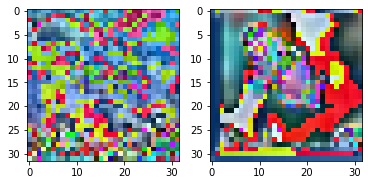

In [6]:
fish_investigation_dataset = DataLoader(fish_train_set, batch_size=2)
fish_data = iter(fish_investigation_dataset)
fish_single_point = next(fish_data)
print(f"""Type: {type(fish_single_point)}
Length: {len(fish_single_point)}
More Types: {type(fish_single_point[0])}, {type(fish_single_point[1])}
Image Shapes: {fish_single_point[0][0].shape}, {fish_single_point[0][1].shape}
Labels: {fish_single_point[1]}
""")

ToPIL = T.ToPILImage()
img0 = ToPIL(fish_single_point[0][0])
img1 = ToPIL(fish_single_point[0][1])
fi_1, axs_1 = plt.subplots(1,2)
axs_1[0].imshow(img0)
axs_1[1].imshow(img1)

<span style="color:black;font-size:35px">**VGG Training**</span>

In [9]:
vgg_learning_rate = 1e-1
vgg_nepochs = 20
fish_batch_size = 64

fish_train_dataset = DataLoader(fish_train_set, batch_size=fish_batch_size)

vgg = VGG16(hidden_features=512, nout=30).to(device)

vgg_optimizer = optim.SGD(vgg.parameters(), lr=vgg_learning_rate)

loss_function = nn.CrossEntropyLoss()

vgg.train()
vgg_loss_history = []
for epoch in tqdm(range(vgg_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    vgg_loss_history.append(train_epoch(model=vgg, 
                                        train_data=fish_train_dataset, 
                                        LossFunction=loss_function, 
                                        optimizer=vgg_optimizer))
    print(f"Epoch {epoch}: loss: {vgg_loss_history[-1][-1]}")

Epoch:   5%|███▌                                                                    | 1/20 [01:52<35:36, 112.47s/epoch]

Epoch 0: loss: 2.6200480461120605


Epoch:  10%|███████▏                                                                | 2/20 [03:43<33:30, 111.70s/epoch]

Epoch 1: loss: 2.252718448638916


Epoch:  15%|██████████▊                                                             | 3/20 [05:46<33:04, 116.73s/epoch]

Epoch 2: loss: 1.7675036191940308


Epoch:  20%|██████████████▍                                                         | 4/20 [07:54<32:19, 121.24s/epoch]

Epoch 3: loss: 1.5173380374908447


Epoch:  25%|██████████████████                                                      | 5/20 [09:57<30:29, 121.97s/epoch]

Epoch 4: loss: 1.206783652305603


Epoch:  30%|█████████████████████▌                                                  | 6/20 [12:00<28:30, 122.19s/epoch]

Epoch 5: loss: 1.0638233423233032


Epoch:  35%|█████████████████████████▏                                              | 7/20 [13:50<25:38, 118.34s/epoch]

Epoch 6: loss: 0.7352747917175293


Epoch:  40%|████████████████████████████▊                                           | 8/20 [15:38<23:00, 115.05s/epoch]

Epoch 7: loss: 0.49444931745529175


Epoch:  45%|████████████████████████████████▍                                       | 9/20 [17:28<20:47, 113.38s/epoch]

Epoch 8: loss: 0.4924974739551544


Epoch:  50%|███████████████████████████████████▌                                   | 10/20 [19:16<18:38, 111.87s/epoch]

Epoch 9: loss: 0.4996935725212097


Epoch:  55%|███████████████████████████████████████                                | 11/20 [21:09<16:48, 112.00s/epoch]

Epoch 10: loss: 0.25151538848876953


Epoch:  60%|██████████████████████████████████████████▌                            | 12/20 [22:56<14:43, 110.40s/epoch]

Epoch 11: loss: 0.24170561134815216


Epoch:  65%|██████████████████████████████████████████████▏                        | 13/20 [24:43<12:45, 109.39s/epoch]

Epoch 12: loss: 0.10356532037258148


Epoch:  70%|█████████████████████████████████████████████████▋                     | 14/20 [26:59<11:44, 117.48s/epoch]

Epoch 13: loss: 0.045256055891513824


Epoch:  75%|█████████████████████████████████████████████████████▎                 | 15/20 [28:52<09:41, 116.30s/epoch]

Epoch 14: loss: 0.08608497679233551


Epoch:  80%|████████████████████████████████████████████████████████▊              | 16/20 [31:01<07:59, 119.89s/epoch]

Epoch 15: loss: 0.08036113530397415


Epoch:  85%|████████████████████████████████████████████████████████████▎          | 17/20 [33:14<06:11, 123.89s/epoch]

Epoch 16: loss: 0.09379636496305466


Epoch:  90%|███████████████████████████████████████████████████████████████▉       | 18/20 [35:04<03:59, 119.71s/epoch]

Epoch 17: loss: 0.05894706770777702


Epoch:  95%|███████████████████████████████████████████████████████████████████▍   | 19/20 [36:51<01:56, 116.04s/epoch]

Epoch 18: loss: 0.013634849339723587


Epoch: 100%|███████████████████████████████████████████████████████████████████████| 20/20 [38:39<00:00, 115.99s/epoch]

Epoch 19: loss: 0.015211792662739754


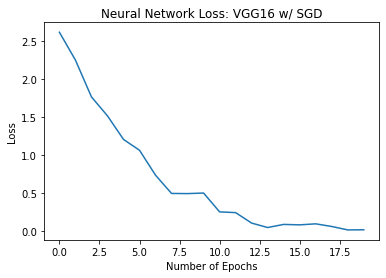

Total accuracy = 74.95%


In [10]:
fish_test_dataset = DataLoader(fish_test_set, batch_size=fish_batch_size)

plt.plot(list(map(lambda x: x[-1], vgg_loss_history)))
plt.title("Neural Network Loss: VGG16 w/ SGD")    
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.show()
vgg_accuracy = evaluate(vgg, fish_test_dataset)
print(f"Total accuracy = {vgg_accuracy / len(fish_test_set)*100:.2f}%")

# Lenet Training

In [7]:
lenet_learning_rate = 0.001
lenet_nepochs = 20
lenet_batch_size = 32

fish_train_dataset = DataLoader(fish_train_set, batch_size=lenet_batch_size)

lenet = LeNet(num_classes=30).to(device)

lenet_optimizer = optim.Adam(lenet.parameters(), lr=lenet_learning_rate)

loss_function = nn.CrossEntropyLoss()

lenet.train()
lenet_loss_history = []
for epoch in tqdm(range(lenet_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    lenet_loss_history.append(train_epoch(model=lenet,
                                          train_data=fish_train_dataset,
                                          LossFunction=loss_function,
                                          optimizer=lenet_optimizer))
    print(f"Epoch {epoch}: loss: {lenet_loss_history[-1][-1]}")

Epoch:   0%|                                                                                 | 0/20 [00:00<?, ?epoch/s]C:\Users\hansm\anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch:   5%|███▋                                                                     | 1/20 [00:39<12:28, 39.41s/epoch]

Epoch 0: loss: 2.538813591003418


Epoch:  10%|███████▎                                                                 | 2/20 [01:20<12:10, 40.57s/epoch]

Epoch 1: loss: 2.2174534797668457


Epoch:  15%|██████████▉                                                              | 3/20 [02:08<12:25, 43.86s/epoch]

Epoch 2: loss: 1.8593628406524658


Epoch:  20%|██████████████▌                                                          | 4/20 [03:01<12:38, 47.39s/epoch]

Epoch 3: loss: 1.6685986518859863


Epoch:  25%|██████████████████▎                                                      | 5/20 [03:52<12:08, 48.58s/epoch]

Epoch 4: loss: 1.6281667947769165


Epoch:  30%|█████████████████████▉                                                   | 6/20 [04:36<10:58, 47.06s/epoch]

Epoch 5: loss: 1.629101037979126


Epoch:  35%|█████████████████████████▌                                               | 7/20 [05:16<09:44, 44.94s/epoch]

Epoch 6: loss: 1.38697350025177


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [05:56<08:40, 43.34s/epoch]

Epoch 7: loss: 1.3358908891677856


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [06:37<07:49, 42.64s/epoch]

Epoch 8: loss: 1.3373141288757324


Epoch:  50%|████████████████████████████████████                                    | 10/20 [07:19<07:02, 42.21s/epoch]

Epoch 9: loss: 1.2801533937454224


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [08:00<06:17, 41.98s/epoch]

Epoch 10: loss: 1.2792212963104248


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [08:40<05:31, 41.39s/epoch]

Epoch 11: loss: 0.8541301488876343


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [09:20<04:46, 40.93s/epoch]

Epoch 12: loss: 0.9248687028884888


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [09:59<04:02, 40.41s/epoch]

Epoch 13: loss: 0.8602514266967773


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [10:46<03:31, 42.28s/epoch]

Epoch 14: loss: 0.7742583155632019


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [11:28<02:49, 42.37s/epoch]

Epoch 15: loss: 0.6747252941131592


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [12:09<02:06, 42.02s/epoch]

Epoch 16: loss: 0.6217914819717407


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [12:50<01:23, 41.53s/epoch]

Epoch 17: loss: 0.5108365416526794


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [13:30<00:41, 41.11s/epoch]

Epoch 18: loss: 0.49507904052734375


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [14:13<00:00, 42.66s/epoch]

Epoch 19: loss: 0.4310540556907654


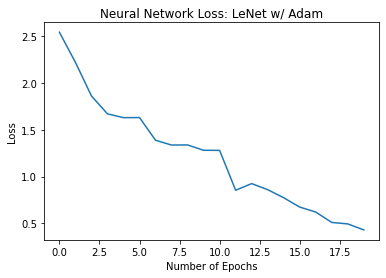

Total accuracy = 58.98%


In [8]:
fish_test_dataset = DataLoader(fish_test_set, batch_size=lenet_batch_size)

plt.plot(list(map(lambda x: x[-1], lenet_loss_history)))
plt.title("Neural Network Loss: LeNet w/ Adam")    
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.show()
lenet_accuracy = evaluate(lenet, fish_test_dataset)
print(f"Total accuracy = {lenet_accuracy / len(fish_test_set)*100:.2f}%")